### Dataset: Brazilian E-Commerce Public Dataset by Olist

Conjunto de dados públicos de comércio eletrônico brasileiro por Olist

Este é um conjunto de dados públicos de comércio eletrônico brasileiro de pedidos feitos na Olist Store. O conjunto de dados contém informações de 100 mil pedidos de 2016 a 2018 feitos em vários marketplaces no Brasil. Seus recursos permitem visualizar um pedido em múltiplas dimensões: desde status do pedido, preço, desempenho de pagamento e frete até localização do cliente, atributos do produto e finalmente avaliações escritas pelos clientes. Também um conjunto de dados de geolocalização que relaciona os CEPs brasileiros às coordenadas lat/lng.

Estes são dados comerciais reais, foram anonimizados e as referências às empresas e parceiros no texto da revisão foram substituídas pelos nomes das grandes casas de Game of Thrones.

Olist, a maior loja de departamentos dos mercados brasileiros. Olist conecta pequenas empresas de todo o Brasil a canais sem complicações e com um único contrato. Esses comerciantes podem vender seus produtos através da Olist Store e enviá-los diretamente aos clientes usando os parceiros logísticos da Olist. Veja mais em nosso site: www.olist.com

Depois que um cliente compra o produto na Olist Store, um vendedor é notificado para atender ao pedido. Assim que o cliente recebe o produto, ou vence a data estimada de entrega, o cliente recebe por e-mail uma pesquisa de satisfação onde pode dar uma nota da experiência de compra e anotar alguns comentários.
Atenção:Um pedido pode ter vários itens.
Cada item pode ser entregue por um vendedor distinto.
Todos os textos de identificação de lojas e parceiros foram substituídos pelos nomes das grandes casas de Game of Thrones.

Link do dataset: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data

O dataset é composto por 9 arquivos csvs, neste estudo abordaremos a análise do perfil dos clientes, abaixo consta a imagem que exemplifica a forma de conexão entre os arquivos.Para o inicio da análise é preciso realizar alguns merges para obter as colunas necessárias  no estudo.

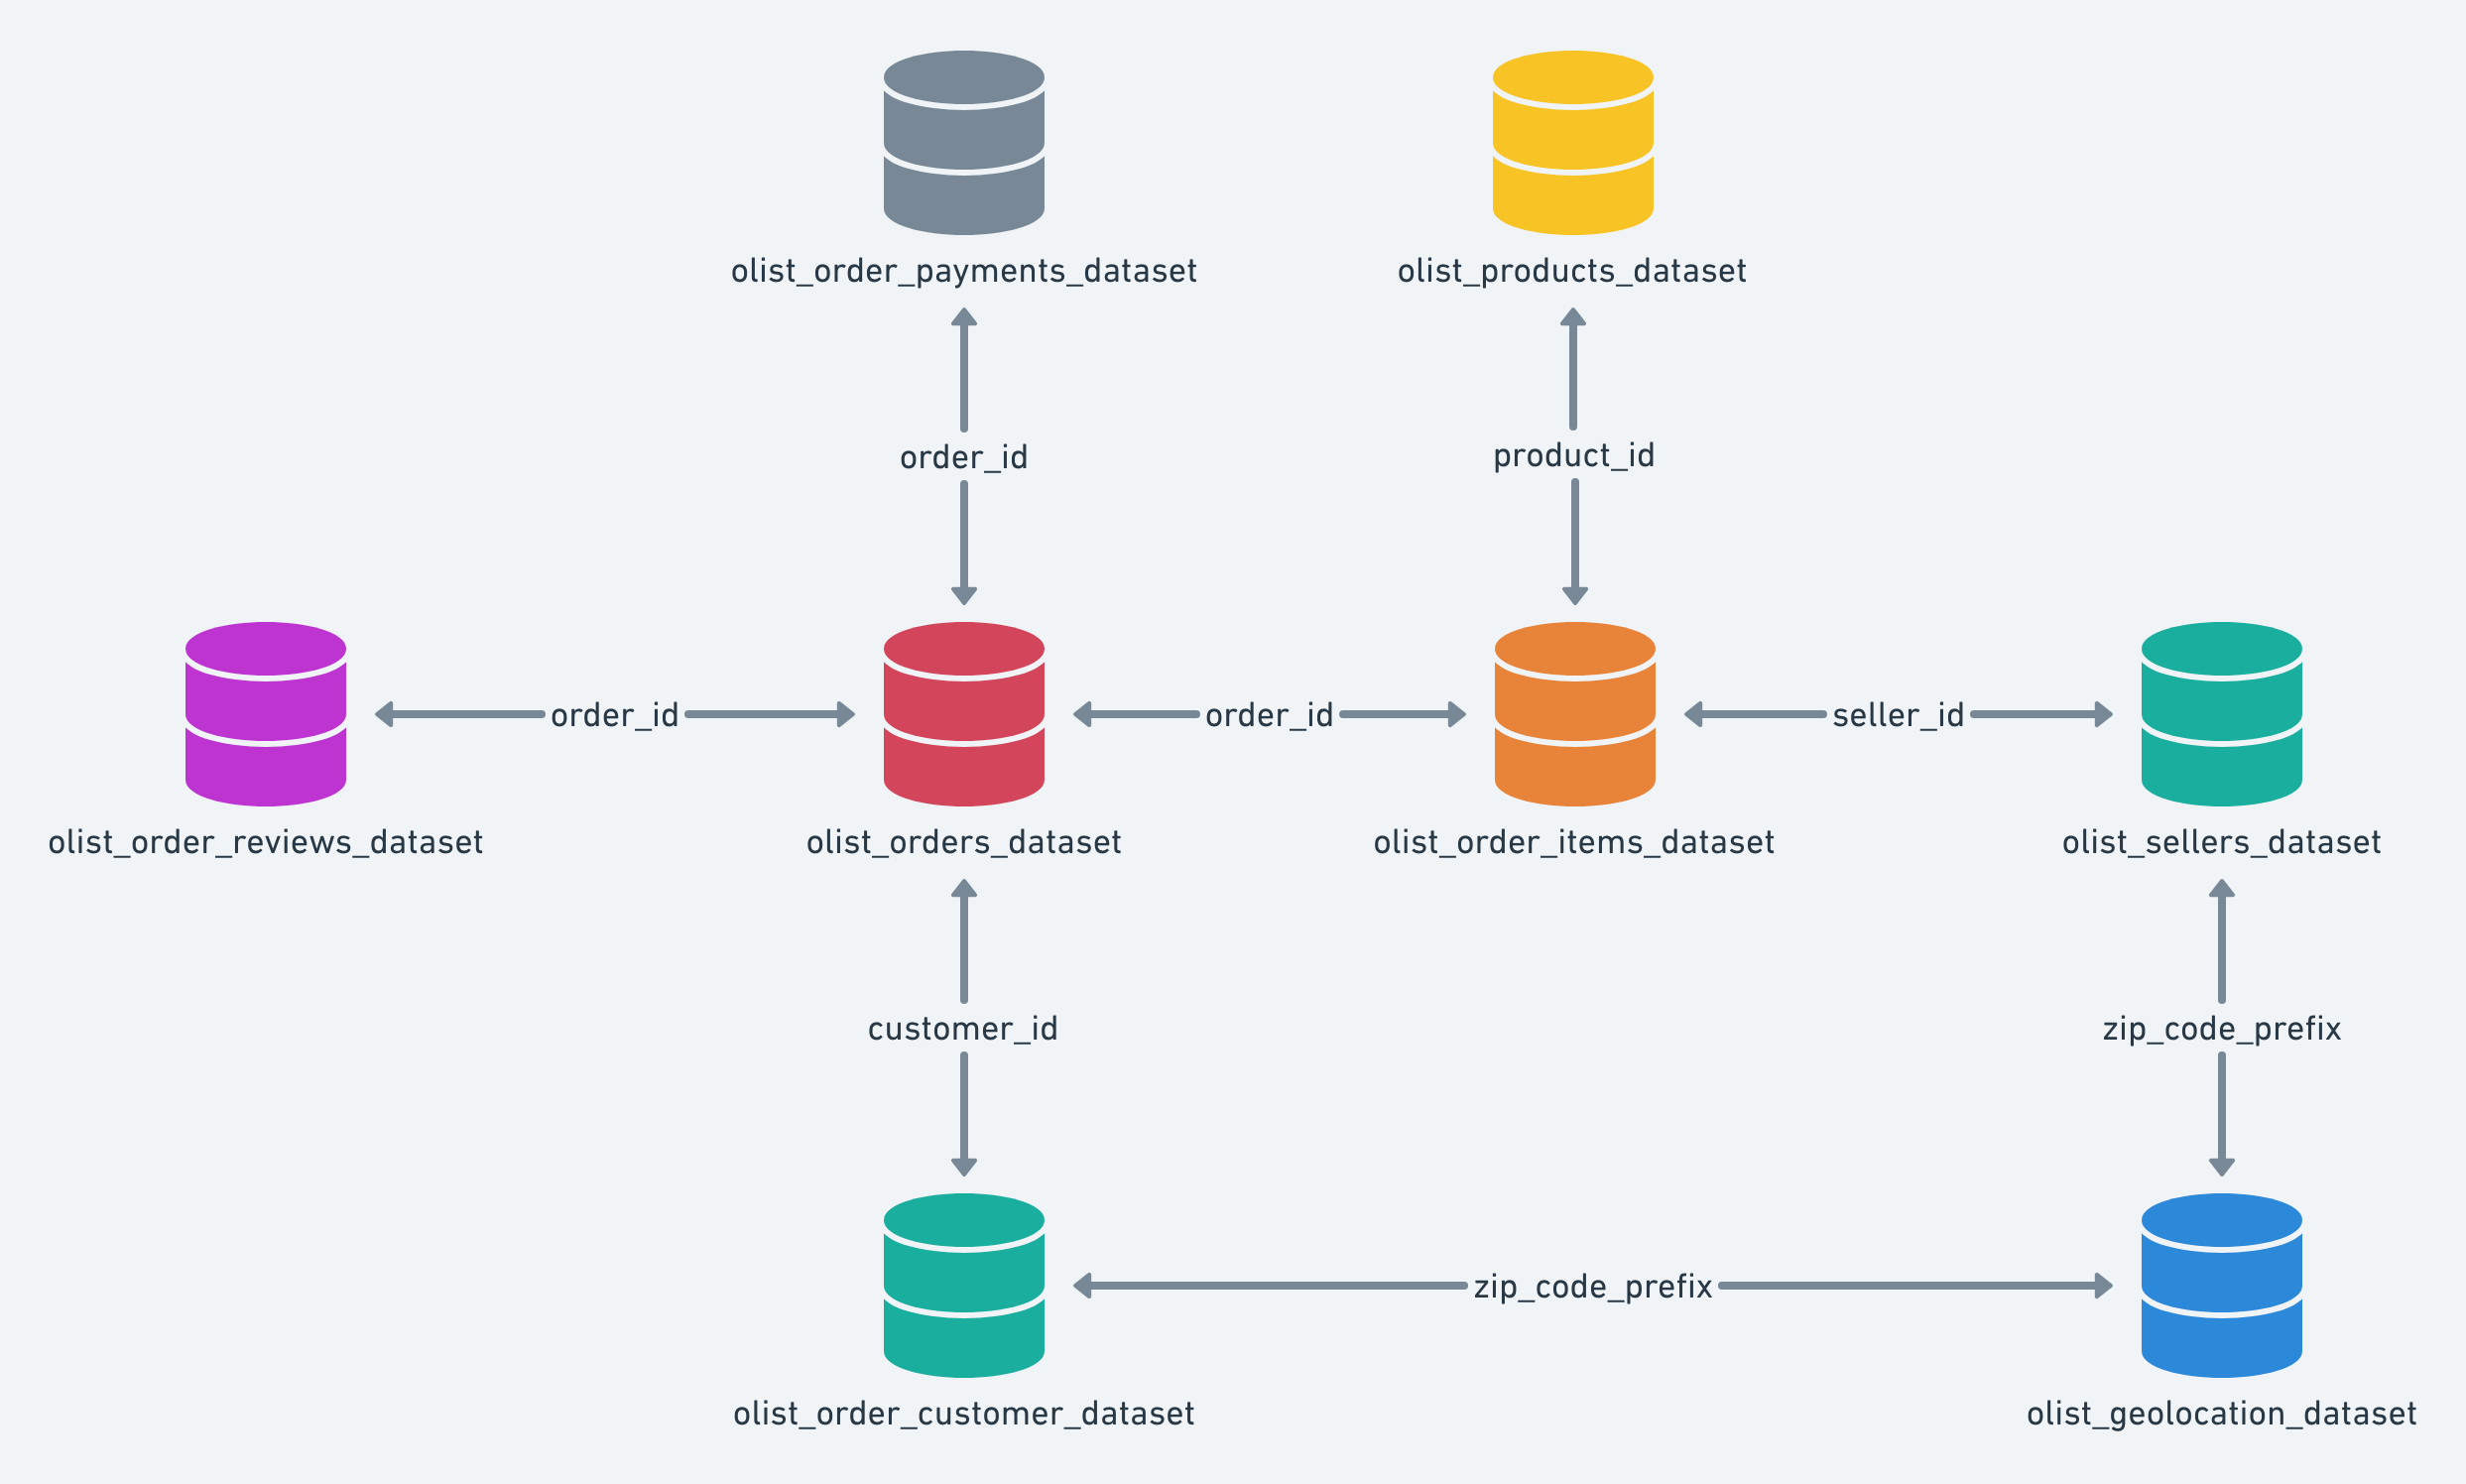

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [96]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
from geopandas.datasets import get_path


from sklearn.preprocessing import scale,StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,silhouette_score,roc_curve,roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans


###Analisando as colunas existentes e as relações com as outras tabelas

In [32]:
order=pd.read_csv("/content/drive/MyDrive/ADA-DS/Machine Learning/Projeto/olist_orders_dataset.csv")
order.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
order_itens=pd.read_csv("/content/drive/MyDrive/ADA-DS/Machine Learning/Projeto/olist_order_items_dataset.csv")
order_itens.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [6]:
order_payments=pd.read_csv("/content/drive/MyDrive/ADA-DS/Machine Learning/Projeto/olist_order_payments_dataset.csv")
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [7]:
products=pd.read_csv("/content/drive/MyDrive/ADA-DS/Machine Learning/Projeto/olist_products_dataset.csv")
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


###Analisando os arquivos de endereço dos clientes, comparando com os dados do arquivo de coordenadas de geolocalização

Nesta análise foi possível verificar que as colunas com nome de cidade não seguem um padrão, ou seja, uma mesma cidade vem escrita com diversas formas diferentes, e os distritos estão vindo como cidades diferentes, e na verdade deveriam vir com o nome da cidade que do qual pertence.Mas ter uma coordenada de localização mais precisa, realizamos o tratamento abaixo.

In [8]:
customers=pd.read_csv("/content/drive/MyDrive/ADA-DS/Machine Learning/Projeto/olist_customers_dataset.csv")
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [9]:
customers[customers['customer_zip_code_prefix'] ==1151]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
17280,8d401266c416fe74129569742199d75f,632b9f83894a36849b293ce84d62d399,1151,sao paulo,SP
27142,4eb9eccb3b24a747f725dbee821a88b7,15f755c9f45213070f1b781ed78ea55c,1151,sao paulo,SP
48774,3532ba38a3fd242259a514ac2b6ae6b6,4fa4365000c7090fcb8cad5713c6d3db,1151,sao paulo,SP
54656,dc6c74aedc9324030804b25fa1021b17,6be824f2933ae5094244f962068ca531,1151,sao paulo,SP
67534,8c55956d70fca64193668429b9f8d8ce,61a7c7a2d1ee1715b63e0d22a1129fc5,1151,sao paulo,SP
81540,e9490b645b17d03cfde928d84d38a916,b00fa88d0838e8f9ecc8c34356655c4e,1151,sao paulo,SP
82361,188ac4e8b7765d24cdb434112a99111f,27a42ae2a62b4442dd98ec2e16193118,1151,sao paulo,SP
91845,020fff139f1af3a6dff28456f386fe2d,00705dcbc0b9cad67abd658612770905,1151,sao paulo,SP


In [10]:
geolocation=pd.read_csv("/content/drive/MyDrive/ADA-DS/Machine Learning/Projeto/olist_geolocation_dataset.csv")
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [11]:
geolocation[geolocation['geolocation_zip_code_prefix'] ==1151]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
1474,1151,-23.527788,-46.660310,sao paulo,SP
1485,1151,-23.531421,-46.656262,sao paulo,SP
1526,1151,-23.531294,-46.656404,sao paulo,SP
1528,1151,-23.533334,-46.654074,sao paulo,SP
1533,1151,-23.532469,-46.656487,sao paulo,SP
...,...,...,...,...,...
3254,1151,-23.530118,-46.657771,sao paulo,SP
3256,1151,-23.531294,-46.656404,sao paulo,SP
3262,1151,-23.530159,-46.657632,sao paulo,SP
3274,1151,-23.533334,-46.654074,sao paulo,SP


In [12]:
quantidade_valores_unicos = customers['customer_city'].nunique()
print("Quantidade de valores únicos na coluna 'customer_city':", quantidade_valores_unicos)

# Exibir todos os valores únicos na coluna 'causa_acidente' em uma linha
valores_unicos = customers['customer_city'].unique()
valores_unicos_str = ', '.join(valores_unicos)
print("Valores únicos na coluna 'customer_city':", valores_unicos_str)

# Salvar todos os valores únicos em um arquivo
with open('valores_unicos_cidades.txt', 'w', encoding='utf-8') as arquivo:
    for valor in valores_unicos:
        arquivo.write(valor + '\n')

print("Valores únicos salvos no arquivo 'valores_unicos_cidades.txt'")

Quantidade de valores únicos na coluna 'customer_city': 4119
Valores únicos na coluna 'customer_city': franca, sao bernardo do campo, sao paulo, mogi das cruzes, campinas, jaragua do sul, timoteo, curitiba, belo horizonte, montes claros, rio de janeiro, lencois paulista, caxias do sul, piracicaba, guarulhos, pacaja, florianopolis, aparecida de goiania, santo andre, goiania, cachoeiro de itapemirim, sao jose dos campos, sao roque, camacari, resende, sumare, novo hamburgo, sao luis, sao jose, santa barbara, ribeirao preto, ituiutaba, taquarituba, sao jose dos pinhais, barrinha, parati, dourados, trindade, cascavel, fortaleza, brasilia, pelotas, porto alegre, salto, jundiai, cacapava, sao vicente, uberlandia, botelhos, sao goncalo, araucaria, nova iguacu, areia branca, campos dos goytacazes, sao carlos, itajuba, cruz das almas, vassouras, feira de santana, niteroi, sobral, divinopolis, paraiba do sul, paulista, carapicuiba, bom principio, astolfo dutra, marialva, sao jose do rio preto, ca

In [13]:
customers.groupby('customer_zip_code_prefix')['customer_city'].apply(list)

customer_zip_code_prefix
1003                                           [sao paulo]
1004                                [sao paulo, sao paulo]
1005     [sao paulo, sao paulo, sao paulo, sao paulo, s...
1006                                [sao paulo, sao paulo]
1007          [sao paulo, sao paulo, sao paulo, sao paulo]
                               ...                        
99960                                   [charrua, charrua]
99965                             [agua santa, agua santa]
99970                                            [ciriaco]
99980                   [david canabarro, david canabarro]
99990                                          [muliterno]
Name: customer_city, Length: 14994, dtype: object

In [14]:
customers.groupby('customer_city')['customer_zip_code_prefix'].apply(list)

customer_city
abadia dos dourados                                [38540, 38540, 38540]
abadiania                                                        [72940]
abaete                 [35620, 35620, 35620, 35620, 35620, 35620, 356...
abaetetuba             [68440, 68440, 68440, 68440, 68440, 68440, 684...
abaiara                                                   [63240, 63240]
                                             ...                        
xinguara               [68557, 68555, 68557, 68555, 68555, 68555, 685...
xique-xique                                        [47400, 47400, 47400]
zacarias                                                  [15265, 15265]
ze doca                              [65365, 65365, 65365, 65365, 65365]
zortea                                                    [89633, 89633]
Name: customer_zip_code_prefix, Length: 4119, dtype: object

Aqui consta o mapeamento para algumas alterações percebidas, tentando padronizar as cidades contidas no arquivo de endereço de clientes.

In [15]:
corrigindo_cidade = {
  ("arraial d'ajuda" , 'BA'): 'porto seguro',
  ('abrantes', 'BA'): 'camacari',
  ('arraial d ajuda', 'BA'): 'porto seguro',
  ('bataipora', 'MS'): 'bataypora',
  ('brasopolis', 'MG'): 'brazopolis',
  ('cachoeiras de macacu', 'RJ'): 'papucaia',
  ('ceilandia', 'DF'): 'brasilia',
  ('colonia vitoria', 'PR'): 'vitoria',
  ('dias d avila', 'BA'): "dias d'avila",
  ('embu', 'SP'): 'embu das artes',
  ('estrela d oeste', 'SP'): "estrela d'oeste",
  ('fragosos', 'SC'): 'campo alegre',
  ('guara', 'DF'): 'brasilia',
  ('itamira', 'BA'): 'apora',
  ('itapage', 'CE'): 'itapaje',
  ('jaguariuna', 'SP'): 'monte alegre do sul',
  ('mogi-mirim', 'SP'): 'mogi mirim',
  ('palmeira d oeste' , 'SP'): "palmeira d'oeste",
  ('parati', 'RJ'): 'paraty',
  ('picarras', 'SC'): 'balneario picarras',
  ('piumhii', 'MG'): 'piumhi',
  ('planaltina', 'GO'): 'planaltina de goias',
  ('porto firme', 'MG'): 'vicosa',
  ('santa barbara d oeste', 'SP'): "santa barbara d'oeste",
  ('santo antonio das queimadas', 'PE'): 'jurema',
  ('sao benedito', 'MG'): 'patrocinio',
  ('sao jorge do oeste', 'PR'): "sao jorge d'oeste",
  ('silvano', 'MG'): 'patrocinio',
  ('sobradinho', 'DF'): 'brasilia',
  ('taguatinga', 'DF'): 'brasilia'
}

customers['customer_city'] = [x.customer_city if (x.customer_city, x.customer_state) not in corrigindo_cidade else corrigindo_cidade[(x.customer_city, x.customer_state)] for x in customers.itertuples()]


In [16]:
mapa_coordenadas_por_cep = {}

for linha in geolocation.itertuples():
    cep = linha.geolocation_zip_code_prefix
    latitude = linha.geolocation_lat
    longitude = linha.geolocation_lng

    if cep not in mapa_coordenadas_por_cep:
        mapa_coordenadas_por_cep[cep] = []

    mapa_coordenadas_por_cep[cep].append((latitude, longitude))



In [17]:
mapa_ceps_por_cidade= {}
mapa_cep_cidade= {} #somente para verificar se os dados estao limpos

for linha in customers.itertuples():
    cep = linha.customer_zip_code_prefix
    cidade_estado = linha.customer_city + "," + linha.customer_state


    if cidade_estado not in mapa_ceps_por_cidade:
        mapa_ceps_por_cidade[cidade_estado] = set()

    if cep not in mapa_cep_cidade:
        mapa_cep_cidade[cep] = set()

    mapa_ceps_por_cidade[cidade_estado].add(cep)
    mapa_cep_cidade[cep].add(cidade_estado)

# somente para verificar se os dados estao limpos
for entrada in mapa_cep_cidade.items():
    cep=entrada[0]
    cidades=entrada[1]

    if len(cidades)>1:
      print(cep,cidades) # se escrever é pq os dados não estão limpos!!!


O dataset é composto apenas de uma coluna de CEP e sabemos que um CEP pode conter inúmeras coordenadas(já que pertencem a uma rua), neste caso estamos pegando cada coordenada correspondente a cada CEP da cidade e pegando um par que o represente.

In [18]:
todas_coordenadas_cidade = {
  cidade_cep[0]:
  [
    coordenadas
    for cep in cidade_cep[1] if cep in mapa_coordenadas_por_cep # tem cep q nao existe no cadastro de geo localizacao
    for coordenadas in mapa_coordenadas_por_cep[cep]
  ]
  for cidade_cep in mapa_ceps_por_cidade.items()
}

cidade_coordenada_central = {
  cidade_coordenadas[0]:
  (
    (min(cidade_coordenadas[1], key = lambda coordenada: coordenada[0])[0] +
    max(cidade_coordenadas[1], key = lambda coordenada: coordenada[0])[0]) / 2, #latitude
    (min(cidade_coordenadas[1], key = lambda coordenada: coordenada[1])[1] +
    max(cidade_coordenadas[1], key = lambda coordenada: coordenada[1])[1]) / 2 #longitude
  )
  for cidade_coordenadas in todas_coordenadas_cidade.items() if len(cidade_coordenadas[1]) > 0 # tem cep q nao existe no cadastro de geo localizacao
}

#print(list(todas_coordenadas_cidade.items())[:2])
print(cidade_coordenada_central)
print(len(cidade_coordenada_central))

{'franca,SP': (-20.532723742577275, -47.407663685207694), 'sao bernardo do campo,SP': (-23.742925723597843, -46.53990050903086), 'sao paulo,SP': (-23.54815691019176, -46.37453780092622), 'mogi das cruzes,SP': (-23.552729727468805, -46.18285011277122), 'campinas,SP': (-22.89196183744755, -46.32388581387446), 'jaragua do sul,SC': (-26.487880881742953, -49.114105155707165), 'timoteo,MG': (-19.558703162371458, -42.627010653999946), 'curitiba,PR': (-26.05401109067998, -49.023988728703046), 'belo horizonte,MG': (-20.25742224330807, -45.23411712872938), 'montes claros,MG': (-16.72660837737402, -43.852269474281094), 'rio de janeiro,RJ': (-22.917137505610988, -43.36478185965061), 'lencois paulista,SP': (-22.59369647888107, -48.79952209657664), 'caxias do sul,RS': (-29.056812498454626, -51.13040437062998), 'piracicaba,SP': (-22.7050283983938, -47.65026726776514), 'guarulhos,SP': (-23.43232969206244, -46.46906676324375), 'pacaja,PA': (-3.774435030011098, -50.57679271170129), 'florianopolis,SC': (

In [19]:
data_list = []

# Percorrendo os itens do dicionário e acumulando os dados na lista
for cidade, coords in cidade_coordenada_central.items():
    data_list.append([cidade, coords[0], coords[1]])

# Criando o DataFrame a partir da lista
dados_geolocalizacao = pd.DataFrame(data_list, columns=['Cidade', 'Latitude', 'Longitude'])


In [20]:
dados_geolocalizacao

,Cidade,Latitude,Longitude
0,"franca,SP",-20.532724,-47.407664
1,"sao bernardo do campo,SP",-23.742926,-46.539901
2,"sao paulo,SP",-23.548157,-46.374538
3,"mogi das cruzes,SP",-23.552730,-46.182850
4,"campinas,SP",-22.891962,-46.323886
...,...,...,...
4224,"queiroz,SP",-21.800677,-50.240107
4225,"natividade da serra,SP",-23.377694,-45.443756
4226,"monte bonito,RS",-31.638807,-52.415534
4227,"sao rafael,RN",-5.804526,-36.885693


In [21]:
dados_geolocalizacao[['cidade', 'estado']] = dados_geolocalizacao['Cidade'].str.split(',', expand=True)


In [23]:
dados_geolocalizacao.drop(columns=['Cidade'],inplace=True)

In [24]:
dados_geolocalizacao

,Latitude,Longitude,cidade,estado
0,-20.532724,-47.407664,franca,SP
1,-23.742926,-46.539901,sao bernardo do campo,SP
2,-23.548157,-46.374538,sao paulo,SP
3,-23.552730,-46.182850,mogi das cruzes,SP
4,-22.891962,-46.323886,campinas,SP
...,...,...,...,...
4224,-21.800677,-50.240107,queiroz,SP
4225,-23.377694,-45.443756,natividade da serra,SP
4226,-31.638807,-52.415534,monte bonito,RS
4227,-5.804526,-36.885693,sao rafael,RN


###Criando um novo arquivo CSV com os dados tratados

In [25]:
dados_geolocalizacao.to_csv('dados_geolocalizacao.csv', index=False)

In [28]:
geolocalizacao=pd.read_csv("/content/dados_geolocalizacao.csv")
geolocalizacao.head()

,Latitude,Longitude,cidade,estado
0,-20.532724,-47.407664,franca,SP
1,-23.742926,-46.539901,sao bernardo do campo,SP
2,-23.548157,-46.374538,sao paulo,SP
3,-23.552730,-46.182850,mogi das cruzes,SP
4,-22.891962,-46.323886,campinas,SP


####Juntando arquivos

In [26]:
dados=pd.merge(order_payments,order_itens,on='order_id')
dados.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,7.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,8.72
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,1,548e5bfe28edceab6b51fa707cc9556f,da8622b14eb17ae2831f4ac5b9dab84a,2017-12-12 12:13:20,89.90,17.88
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,1,386486367c1f9d4f587a8864ccb6902b,cca3071e3e9bb7d12640c9fbe2301306,2018-05-31 16:14:41,113.57,14.88


In [33]:
dados=pd.merge(dados,order,on='order_id')
dados.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,...,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,...,17.0,27.0,17.0,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00
1,d86305c284cecff56c7ee9d3fbd4f8d6,1,credit_card,4,93.72,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-04-19 23:10:02,79.80,...,17.0,27.0,17.0,0e37385834260d6111727103a93e790a,delivered,2018-04-15 22:53:59,2018-04-15 23:10:32,2018-04-16 23:54:55,2018-04-20 00:07:39,2018-05-09 00:00:00
2,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,...,16.0,6.0,11.0,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16 00:00:00
3,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,...,20.0,8.0,21.0,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04 00:00:00
4,1966886b80f14d0588adf6406afb0026,1,debit_card,1,68.89,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-09-01 16:06:59,56.99,...,20.0,8.0,21.0,7238ed1e0d25683b9b65e1039e9d942b,invoiced,2017-08-22 16:01:44,2017-08-23 16:06:59,NaN,NaN,2017-09-19 00:00:00


In [34]:
dados=pd.merge(dados,products,on='product_id')
dados.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,...,order_delivered_customer_date,order_estimated_delivery_date,product_category_name_y,product_name_lenght_y,product_description_lenght_y,product_photos_qty_y,product_weight_g_y,product_length_cm_y,product_height_cm_y,product_width_cm_y
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,...,2018-05-09 17:36:51,2018-05-22 00:00:00,casa_construcao,57.0,921.0,8.0,800.0,17.0,27.0,17.0
1,d86305c284cecff56c7ee9d3fbd4f8d6,1,credit_card,4,93.72,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-04-19 23:10:02,79.80,...,2018-04-20 00:07:39,2018-05-09 00:00:00,casa_construcao,57.0,921.0,8.0,800.0,17.0,27.0,17.0
2,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,...,2018-06-29 20:32:09,2018-07-16 00:00:00,automotivo,59.0,1274.0,2.0,150.0,16.0,6.0,11.0
3,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,...,2017-12-18 17:24:41,2018-01-04 00:00:00,perfumaria,54.0,1536.0,2.0,250.0,20.0,8.0,21.0
4,1966886b80f14d0588adf6406afb0026,1,debit_card,1,68.89,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-09-01 16:06:59,56.99,...,NaN,2017-09-19 00:00:00,perfumaria,54.0,1536.0,2.0,250.0,20.0,8.0,21.0


In [35]:
dados=pd.merge(dados,customers,on='customer_id')
dados.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,...,product_description_lenght_y,product_photos_qty_y,product_weight_g_y,product_length_cm_y,product_height_cm_y,product_width_cm_y,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,...,921.0,8.0,800.0,17.0,27.0,17.0,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG
1,d86305c284cecff56c7ee9d3fbd4f8d6,1,credit_card,4,93.72,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-04-19 23:10:02,79.80,...,921.0,8.0,800.0,17.0,27.0,17.0,550a1a0e8ad53e4147e6c761b5699c2b,14781,barretos,SP
2,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,...,1274.0,2.0,150.0,16.0,6.0,11.0,a8b9d3a27068454b1c98cc67d4e31e6f,2422,sao paulo,SP
3,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,...,1536.0,2.0,250.0,20.0,8.0,21.0,6f70c0b2f7552832ba46eb57b1c5651e,2652,sao paulo,SP
4,1966886b80f14d0588adf6406afb0026,1,debit_card,1,68.89,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-09-01 16:06:59,56.99,...,1536.0,2.0,250.0,20.0,8.0,21.0,8a9a81879cbda02fa71d4addfb1a446c,37550,pouso alegre,MG


In [40]:
dados['order_item_id'].unique()

array([ 1,  3,  4,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

In [36]:
dados=pd.merge(
    dados,
    geolocalizacao,
    left_on=['customer_city','customer_state'],
    right_on=['cidade','estado'])
dados.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,...,product_height_cm_y,product_width_cm_y,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,Latitude,Longitude,cidade,estado
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.8,...,27.0,17.0,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG,-17.756379,-41.486759,teofilo otoni,MG
1,5b9a0e4cbfc2d6a1347472c847a4a4e1,1,boleto,1,258.41,3,0bcc3eeca39e1064258aa1e932269894,1f50f920176fa81dab994f9023523100,2018-05-28 09:14:33,53.9,...,22.0,40.0,ed4c785e11a78a73c48fa3af98008292,39800,teofilo otoni,MG,-17.756379,-41.486759,teofilo otoni,MG
2,5b9a0e4cbfc2d6a1347472c847a4a4e1,1,boleto,1,258.41,4,0bcc3eeca39e1064258aa1e932269894,1f50f920176fa81dab994f9023523100,2018-05-28 09:14:33,53.9,...,22.0,40.0,ed4c785e11a78a73c48fa3af98008292,39800,teofilo otoni,MG,-17.756379,-41.486759,teofilo otoni,MG
3,5b9a0e4cbfc2d6a1347472c847a4a4e1,1,boleto,1,258.41,1,389d119b48cf3043d311335e499d9c6b,1f50f920176fa81dab994f9023523100,2018-05-28 09:14:33,53.9,...,22.0,40.0,ed4c785e11a78a73c48fa3af98008292,39800,teofilo otoni,MG,-17.756379,-41.486759,teofilo otoni,MG
4,5b9a0e4cbfc2d6a1347472c847a4a4e1,1,boleto,1,258.41,2,774e21c631ca26cba7b5606bdca7460f,382229d1e840115ffe3dbf5ff460e417,2018-05-28 09:14:33,39.9,...,4.0,21.0,ed4c785e11a78a73c48fa3af98008292,39800,teofilo otoni,MG,-17.756379,-41.486759,teofilo otoni,MG


###Analisando as colunas que permanecerão no dataset e as que serão dropadas.

In [47]:
df=dados.copy()
df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,...,product_height_cm_y,product_width_cm_y,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,Latitude,Longitude,cidade,estado
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.8,...,27.0,17.0,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG,-17.756379,-41.486759,teofilo otoni,MG
1,5b9a0e4cbfc2d6a1347472c847a4a4e1,1,boleto,1,258.41,3,0bcc3eeca39e1064258aa1e932269894,1f50f920176fa81dab994f9023523100,2018-05-28 09:14:33,53.9,...,22.0,40.0,ed4c785e11a78a73c48fa3af98008292,39800,teofilo otoni,MG,-17.756379,-41.486759,teofilo otoni,MG
2,5b9a0e4cbfc2d6a1347472c847a4a4e1,1,boleto,1,258.41,4,0bcc3eeca39e1064258aa1e932269894,1f50f920176fa81dab994f9023523100,2018-05-28 09:14:33,53.9,...,22.0,40.0,ed4c785e11a78a73c48fa3af98008292,39800,teofilo otoni,MG,-17.756379,-41.486759,teofilo otoni,MG
3,5b9a0e4cbfc2d6a1347472c847a4a4e1,1,boleto,1,258.41,1,389d119b48cf3043d311335e499d9c6b,1f50f920176fa81dab994f9023523100,2018-05-28 09:14:33,53.9,...,22.0,40.0,ed4c785e11a78a73c48fa3af98008292,39800,teofilo otoni,MG,-17.756379,-41.486759,teofilo otoni,MG
4,5b9a0e4cbfc2d6a1347472c847a4a4e1,1,boleto,1,258.41,2,774e21c631ca26cba7b5606bdca7460f,382229d1e840115ffe3dbf5ff460e417,2018-05-28 09:14:33,39.9,...,4.0,21.0,ed4c785e11a78a73c48fa3af98008292,39800,teofilo otoni,MG,-17.756379,-41.486759,teofilo otoni,MG


In [48]:
df.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name_x', 'product_name_lenght_x',
       'product_description_lenght_x', 'product_photos_qty_x',
       'product_weight_g_x', 'product_length_cm_x', 'product_height_cm_x',
       'product_width_cm_x', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'product_category_name_y',
       'product_name_lenght_y', 'product_description_lenght_y',
       'product_photos_qty_y', 'product_weight_g_y', 'product_length_cm_y',
       'product_height_cm_y', 'product_width_cm_y', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'Latitude', 'Longitude', 'cidade', 'estado'],
      

###Deletando colunas que não serão utilizadas neste estudo

In [49]:
df.drop(columns=['order_item_id','seller_id','customer_id','customer_zip_code_prefix', 'cidade', 'estado','shipping_limit_date','product_name_lenght_x','product_description_lenght_x', 'product_photos_qty_x','product_weight_g_x', 'product_length_cm_x', 'product_height_cm_x',
       'product_width_cm_x', 'customer_id','order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date','order_estimated_delivery_date', 'product_category_name_y', 'product_name_lenght_y', 'product_description_lenght_y','product_photos_qty_y', 'product_weight_g_y', 'product_length_cm_y',
       'product_height_cm_y', 'product_width_cm_y', 'customer_unique_id','customer_zip_code_prefix','order_status'],inplace=True)

In [50]:
df

,order_id,payment_sequential,payment_type,payment_installments,payment_value,product_id,price,freight_value,product_category_name_x,customer_city,customer_state,Latitude,Longitude
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,af74cc53dcffc8384b29e7abfa41902b,79.80,19.53,casa_construcao,teofilo otoni,MG,-17.756379,-41.486759
1,5b9a0e4cbfc2d6a1347472c847a4a4e1,1,boleto,1,258.41,0bcc3eeca39e1064258aa1e932269894,53.90,18.18,ferramentas_jardim,teofilo otoni,MG,-17.756379,-41.486759
2,5b9a0e4cbfc2d6a1347472c847a4a4e1,1,boleto,1,258.41,0bcc3eeca39e1064258aa1e932269894,53.90,18.18,ferramentas_jardim,teofilo otoni,MG,-17.756379,-41.486759
3,5b9a0e4cbfc2d6a1347472c847a4a4e1,1,boleto,1,258.41,389d119b48cf3043d311335e499d9c6b,53.90,9.09,ferramentas_jardim,teofilo otoni,MG,-17.756379,-41.486759
4,5b9a0e4cbfc2d6a1347472c847a4a4e1,1,boleto,1,258.41,774e21c631ca26cba7b5606bdca7460f,39.90,11.36,esporte_lazer,teofilo otoni,MG,-17.756379,-41.486759
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117537,1e13bca551a3fd095b40e24798569805,1,credit_card,5,137.10,e4db070498b75e666a0736eb2f0abcd4,86.00,51.10,fashion_bolsas_e_acessorios,sao mamede,PB,-6.927393,-37.097362
117538,117ce86d1ddbcdf65da3ff7fe763ed09,1,credit_card,4,142.01,70ad1cce006c26381f72387a1cdb2bf6,123.89,18.12,informatica_acessorios,barreira,CE,-4.290234,-38.641443
117539,8a096b1a1ab9573d96ff53df946afc68,1,boleto,1,47.29,8657986fc307b1b749c57763b90795f8,28.99,18.30,telefonia,paraiso do sul,RS,-29.701362,-53.170936
117540,06eed67b7a87cac349143f3319c2b9fe,1,debit_card,1,192.32,f444092e1a9f9dedb91cf0717d6c4cff,139.00,53.32,automotivo,caldas brandao,PB,-7.156304,-35.350227


###organizando a ordem das colunas e nomes, para facilitar a leitura.

In [51]:
df = df.loc[:, ['product_id', 'order_id', 'product_category_name_x','price','freight_value','payment_value','payment_sequential','payment_type','payment_installments','customer_city','customer_state','Latitude','Longitude']]

In [55]:
df.rename(columns={'product_category_name_x':'product_category_name'},inplace=True)

In [57]:
df

,product_id,order_id,product_category_name,price,freight_value,payment_value,payment_sequential,payment_type,payment_installments,customer_city,customer_state,Latitude,Longitude
0,af74cc53dcffc8384b29e7abfa41902b,b81ef226f3fe1789b1e8b2acac839d17,casa_construcao,79.80,19.53,99.33,1,credit_card,8,teofilo otoni,MG,-17.756379,-41.486759
1,0bcc3eeca39e1064258aa1e932269894,5b9a0e4cbfc2d6a1347472c847a4a4e1,ferramentas_jardim,53.90,18.18,258.41,1,boleto,1,teofilo otoni,MG,-17.756379,-41.486759
2,0bcc3eeca39e1064258aa1e932269894,5b9a0e4cbfc2d6a1347472c847a4a4e1,ferramentas_jardim,53.90,18.18,258.41,1,boleto,1,teofilo otoni,MG,-17.756379,-41.486759
3,389d119b48cf3043d311335e499d9c6b,5b9a0e4cbfc2d6a1347472c847a4a4e1,ferramentas_jardim,53.90,9.09,258.41,1,boleto,1,teofilo otoni,MG,-17.756379,-41.486759
4,774e21c631ca26cba7b5606bdca7460f,5b9a0e4cbfc2d6a1347472c847a4a4e1,esporte_lazer,39.90,11.36,258.41,1,boleto,1,teofilo otoni,MG,-17.756379,-41.486759
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117537,e4db070498b75e666a0736eb2f0abcd4,1e13bca551a3fd095b40e24798569805,fashion_bolsas_e_acessorios,86.00,51.10,137.10,1,credit_card,5,sao mamede,PB,-6.927393,-37.097362
117538,70ad1cce006c26381f72387a1cdb2bf6,117ce86d1ddbcdf65da3ff7fe763ed09,informatica_acessorios,123.89,18.12,142.01,1,credit_card,4,barreira,CE,-4.290234,-38.641443
117539,8657986fc307b1b749c57763b90795f8,8a096b1a1ab9573d96ff53df946afc68,telefonia,28.99,18.30,47.29,1,boleto,1,paraiso do sul,RS,-29.701362,-53.170936
117540,f444092e1a9f9dedb91cf0717d6c4cff,06eed67b7a87cac349143f3319c2b9fe,automotivo,139.00,53.32,192.32,1,debit_card,1,caldas brandao,PB,-7.156304,-35.350227


###Colunas no dataset

    product_id: Identificador único para cada produto no dataset.
    order_id : Identificado único para cada pedido no dataset- lembrando que em um pedido podem existir vários produtos.
    product_category_name: Categoria do produto, como "eletrônicos", "livros", "roupas", etc.
    price: o valor do produto.
    freight_value: Valor do frete para a entrega do produto.
    payment_value é o valor do pedido.
    payment_sequential: Número sequencial do pagamento, representando a ordem dos pagamentos relacionados a um pedido específico.
    payment_type: Tipo de pagamento utilizado, como cartão de crédito, boleto bancário, voucher, ou transferência bancária.
    payment_installments: Número de parcelas em que o pagamento foi dividido.
    payment_value: Valor total pago na transação.
    customer_city: Cidade onde o cliente está localizado.
    customer_state: Estado onde o cliente está localizado.
    latitude e longitude : daquela cidade

#Iniciando a análise dos dados

O info mostra a quantidade de colunas existentes no dataset, se existem valores nulos e o tipo de dados contido em cada uma das colunas.

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117542 entries, 0 to 117541
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   product_id             117542 non-null  object 
 1   order_id               117542 non-null  object 
 2   product_category_name  115845 non-null  object 
 3   price                  117542 non-null  float64
 4   freight_value          117542 non-null  float64
 5   payment_value          117542 non-null  float64
 6   payment_sequential     117542 non-null  int64  
 7   payment_type           117542 non-null  object 
 8   payment_installments   117542 non-null  int64  
 9   customer_city          117542 non-null  object 
 10  customer_state         117542 non-null  object 
 11  Latitude               117542 non-null  float64
 12  Longitude              117542 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 11.7+ MB


####Tratando dados nulos(não fiz) achei que não tinha dados nulos e tem

O describe exibe valores estatísticos dos dados como: média,desvio padrão,a divisão dos dados em quartis, o valor máximo e o valor mínimo. Em um cenário  perfeito os dados deveriam se aproximar de uma distribuição normal

In [60]:
df.describe()

,price,freight_value,payment_value,payment_sequential,payment_installments,Latitude,Longitude
count,117542.000000,117542.000000,117542.000000,117542.000000,117542.000000,117542.000000,117542.000000
mean,120.822851,20.042693,172.698967,1.093558,2.939528,-21.154203,-46.404005
std,184.483985,15.859672,267.626975,0.726861,2.774330,5.647291,4.382648
min,0.850000,0.000000,0.000000,1.000000,0.000000,-33.688032,-72.601816
25%,39.900000,13.080000,60.870000,1.000000,1.000000,-23.548157,-48.491412
50%,74.900000,16.290000,108.220000,1.000000,2.000000,-22.917138,-46.374538
75%,134.900000,21.190000,189.275000,1.000000,4.000000,-20.257422,-43.512244
max,6735.000000,409.680000,13664.080000,29.000000,24.000000,42.184003,-8.723762


O boxplot permite analisar se existem valores discrepantes em cada coluna númerica, os famosos outliers. Analisando todas as colunas possuem, e a próxima questão seria como tratá-los? Neste caso por se tratar de valores de produtos não podemos modificar, já que na realidade existem produtos com preços diferentes, bem como a quantidade de vezes que é permitido parcelar.

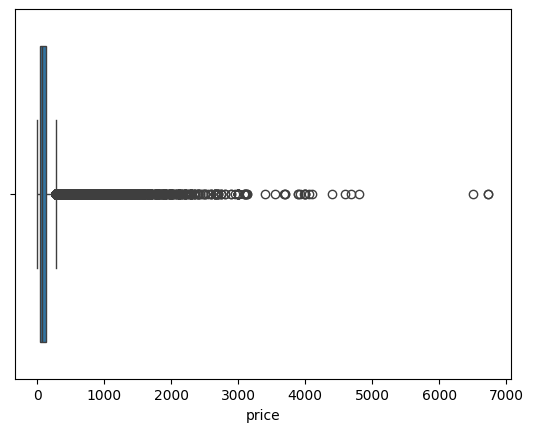

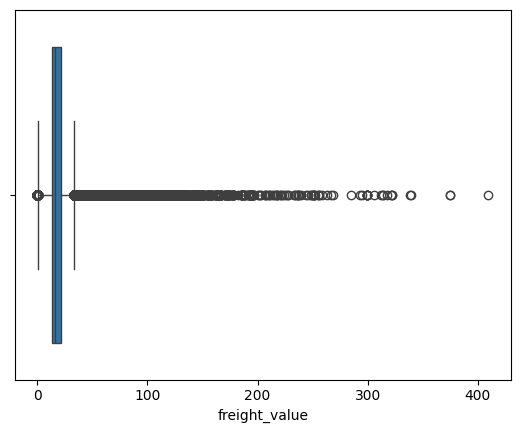

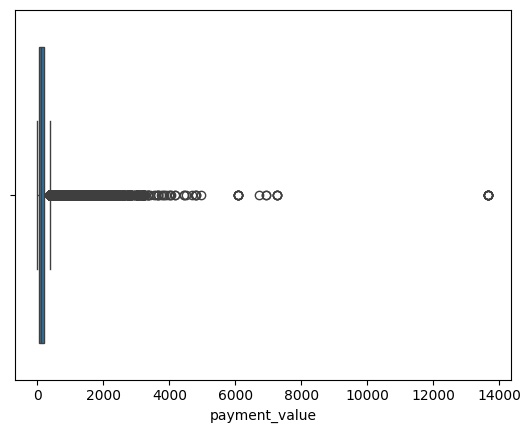

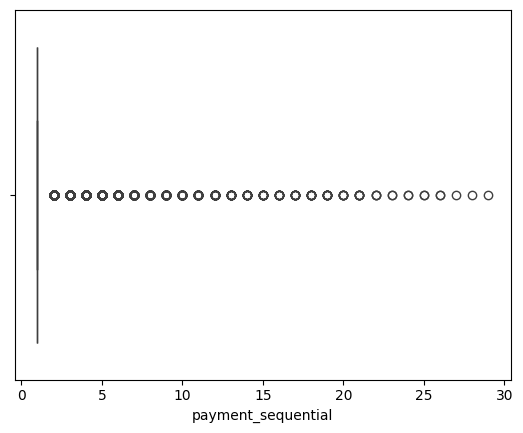

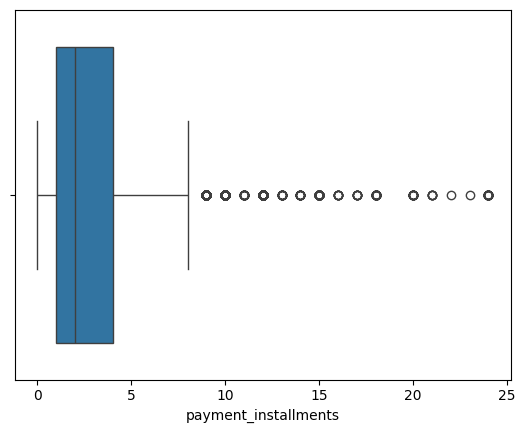

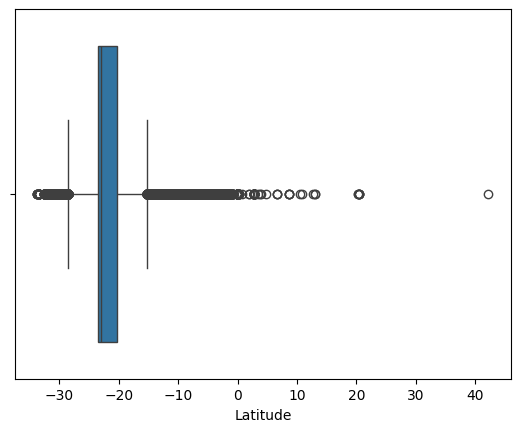

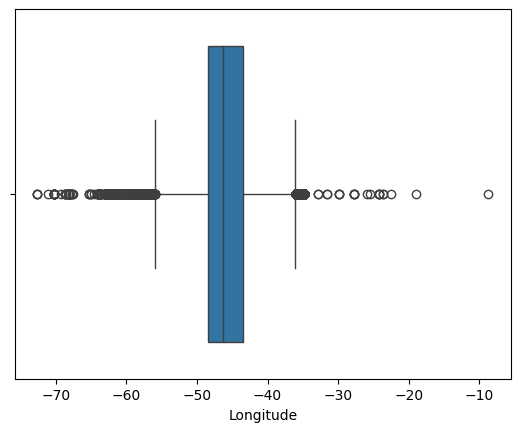

In [61]:
for col in df.select_dtypes(include=np.number).columns:
  sns.boxplot(data=df, x=col)
  plt.show()

O código abaixo mostra as dez categorias mais vendidas. Em primeiro lugar temos: cama mesa e banho, em segundo produtos de limpeza e em terceiro esporte e lazer. O dataset não contém nome de produtos, apenas nome das categorias.

In [65]:
df['product_category_name'].value_counts().to_frame(name='count').reset_index().head(10)

,product_category_name,count
0,cama_mesa_banho,11819
1,beleza_saude,9964
2,esporte_lazer,8942
3,moveis_decoracao,8742
4,informatica_acessorios,8081
5,utilidades_domesticas,7355
6,relogios_presentes,6197
7,telefonia,4718
8,ferramentas_jardim,4570
9,automotivo,4375


In [68]:
df['product_category_name'].value_counts(normalize=True).to_frame(name='count').reset_index()

,product_category_name,count
0,cama_mesa_banho,0.102024
1,beleza_saude,0.086011
2,esporte_lazer,0.077189
3,moveis_decoracao,0.075463
4,informatica_acessorios,0.069757
...,...,...
68,portateis_cozinha_e_preparadores_de_alimentos,0.000129
69,cds_dvds_musicais,0.000121
70,pc_gamer,0.000086
71,fashion_roupa_infanto_juvenil,0.000069


Nesta parte é possível notar a forma de pagamento mais comum, em primeiro lugar temos o cartão de crédito, por incrivel que pareça o segundo é o boleto, o terceito voucher e por ultimo o cartão de débito.

In [71]:
df['payment_type'].value_counts().to_frame(name='count').reset_index()

,payment_type,count
0,credit_card,86725
1,boleto,22855
2,voucher,6272
3,debit_card,1690


In [70]:
df['payment_type'].value_counts(normalize=True).to_frame(name='count').reset_index()

,payment_type,count
0,credit_card,0.737821
1,boleto,0.194441
2,voucher,0.053360
3,debit_card,0.014378


Neste caso da pra ver a quantidade de parcelamentos por tipo de pagamento, a média é de 3 vezes no cartão.

In [72]:
df.groupby('payment_type')['payment_installments'].mean().to_frame(name='payment_installments_mean').reset_index()

,payment_type,payment_installments_mean
0,boleto,1.000000
1,credit_card,3.628723
2,debit_card,1.000000
3,voucher,1.000000


Vamos analisar por regiões. Da pra notar que o maior volume de compras é efetuado pelas grandes capitais: São Paulo, Rio de Janeiro,Belo horizonte, e a forma de pagamento mais utilizada é cartão de crédito.

In [79]:
(df.groupby(['customer_state','customer_city'])['payment_type'].value_counts().to_frame(name='count')).sort_values(by='count', ascending=False)

count
customer_state customer_city         payment_type       
SP             sao paulo             credit_card   13933
RJ             rio de janeiro        credit_card    6248
SP             sao paulo             boleto         3297
MG             belo horizonte        credit_card    2527
DF             brasilia              credit_card    1914
...                                                  ...
MG             gameleiras            credit_card       1
RS             bento goncalves       voucher           1
               boa vista das missoes credit_card       1
               boa vista do burica   boleto            1
TO             xambioa               credit_card       1

[7592 rows x 1 columns]

Em relação a cidades pequenas, a quantidade de vezes que ocorre o parcelamento é grande.

In [87]:
(df.groupby(['customer_state', 'customer_city','payment_type']).agg({'payment_installments': 'mean'}).sort_values(by='payment_installments', ascending=False))

payment_installments
customer_state customer_city               payment_type                      
GO             ipiranga de goias           credit_card                   14.0
BA             quijingue                   credit_card                   14.0
MA             sao bernardo                credit_card                   12.0
MG             sao pedro da uniao          credit_card                   12.0
SE             neopolis                    credit_card                   12.0
...                                                                       ...
RJ             engenheiro paulo de frontin boleto                         1.0
               goitacazes                  boleto                         1.0
                                           voucher                        1.0
               governador portela          boleto                         1.0
BA             sapeacu                     boleto                         1.0

[7592 rows x 1 columns]

Vamos analisar a relação das variáveis existentes para iniciar uma modelagem de Machine Learning para analisar o perfil de clientes.

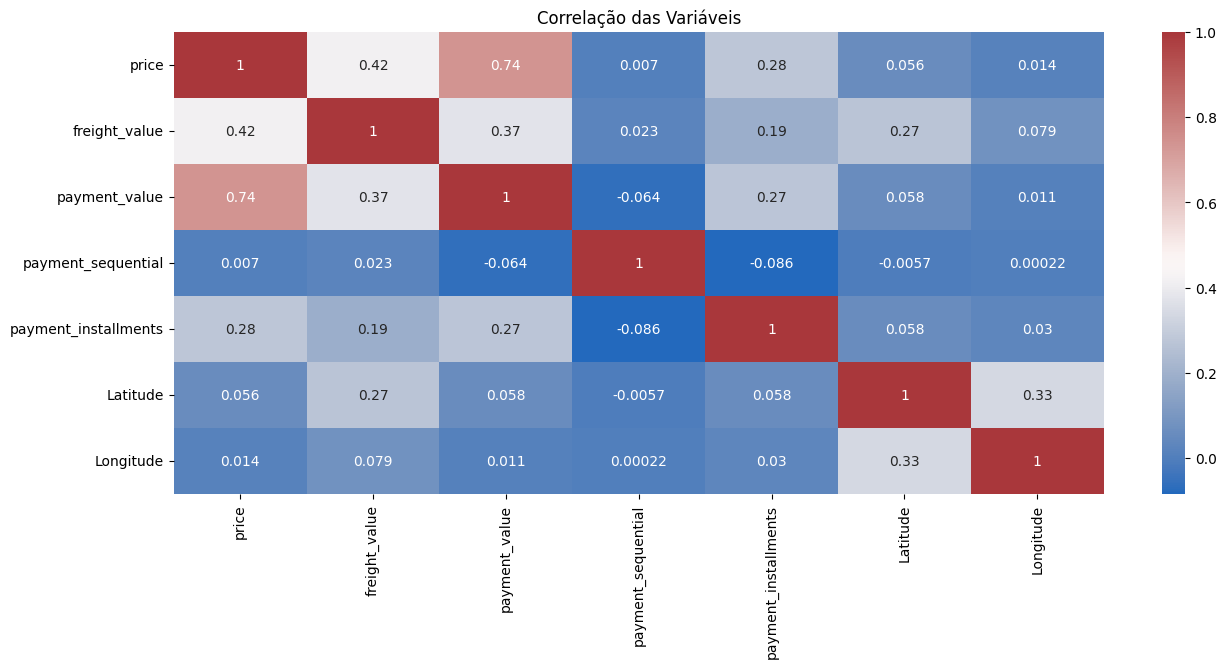

In [88]:
var_num=df.describe().columns.tolist()
plt.figure(figsize=(15,6))
sns.heatmap(data=df[var_num].corr(), annot=True, cmap="vlag")
plt.title("Correlação das Variáveis")
plt.show()

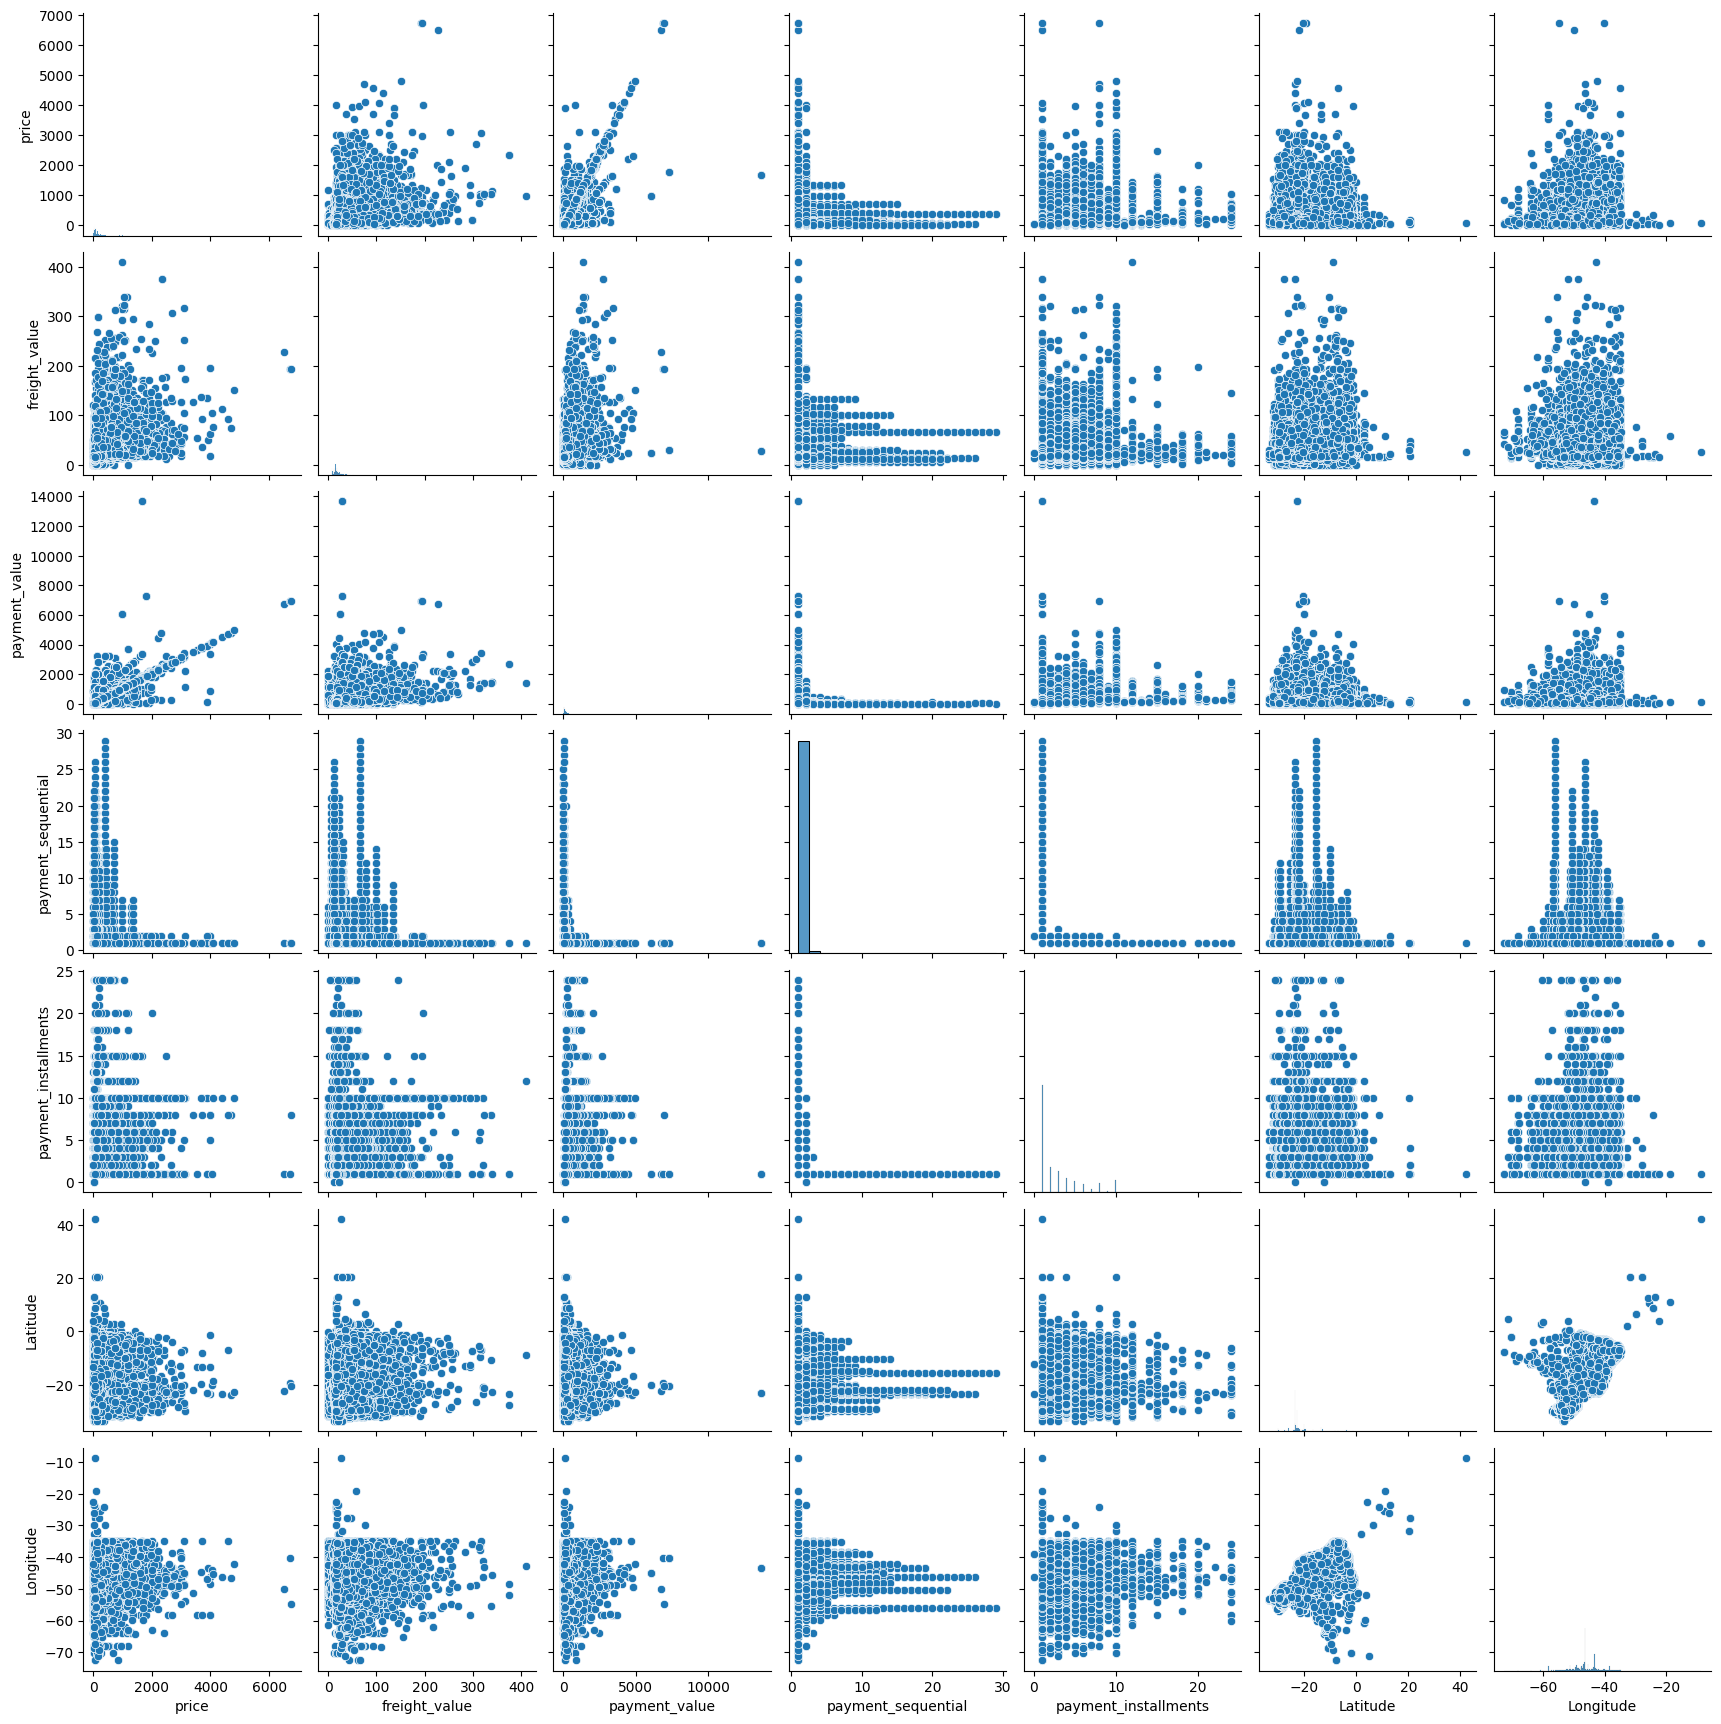

In [89]:
sns.pairplot(df)

###Alterando a váveriavei categorica de tipos de pagamento usando o label encolder

In [91]:
le = LabelEncoder()
df['payment_type_encoded'] = le.fit_transform(df['payment_type'])

In [92]:
df.head()

,product_id,order_id,product_category_name,price,freight_value,payment_value,payment_sequential,payment_type,payment_installments,customer_city,customer_state,Latitude,Longitude,payment_type_encoded
0,af74cc53dcffc8384b29e7abfa41902b,b81ef226f3fe1789b1e8b2acac839d17,casa_construcao,79.8,19.53,99.33,1,credit_card,8,teofilo otoni,MG,-17.756379,-41.486759,1
1,0bcc3eeca39e1064258aa1e932269894,5b9a0e4cbfc2d6a1347472c847a4a4e1,ferramentas_jardim,53.9,18.18,258.41,1,boleto,1,teofilo otoni,MG,-17.756379,-41.486759,0
2,0bcc3eeca39e1064258aa1e932269894,5b9a0e4cbfc2d6a1347472c847a4a4e1,ferramentas_jardim,53.9,18.18,258.41,1,boleto,1,teofilo otoni,MG,-17.756379,-41.486759,0
3,389d119b48cf3043d311335e499d9c6b,5b9a0e4cbfc2d6a1347472c847a4a4e1,ferramentas_jardim,53.9,9.09,258.41,1,boleto,1,teofilo otoni,MG,-17.756379,-41.486759,0
4,774e21c631ca26cba7b5606bdca7460f,5b9a0e4cbfc2d6a1347472c847a4a4e1,esporte_lazer,39.9,11.36,258.41,1,boleto,1,teofilo otoni,MG,-17.756379,-41.486759,0


In [98]:
#X = df.drop(columns=['product_id','order_id','product_category_name','payment_type'])
X=df[['payment_value','payment_type_encoded','Longitude','payment_type_encoded']]
# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

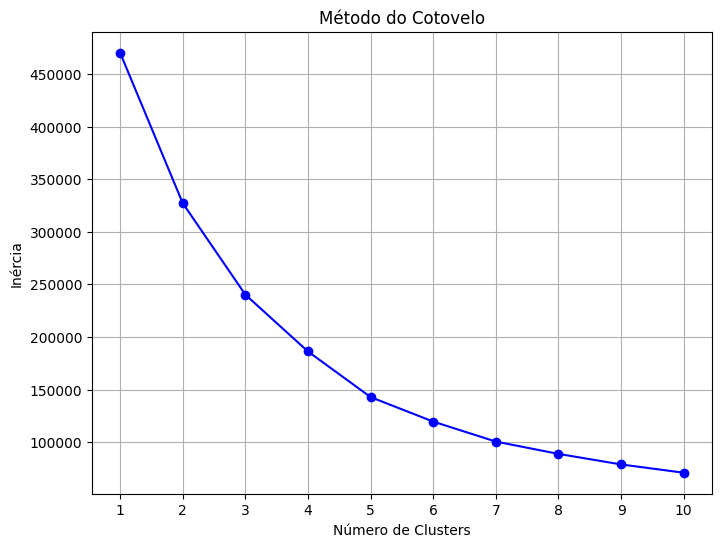

In [94]:
inertia = []

# Calcular a inércia para diferentes valores de k
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

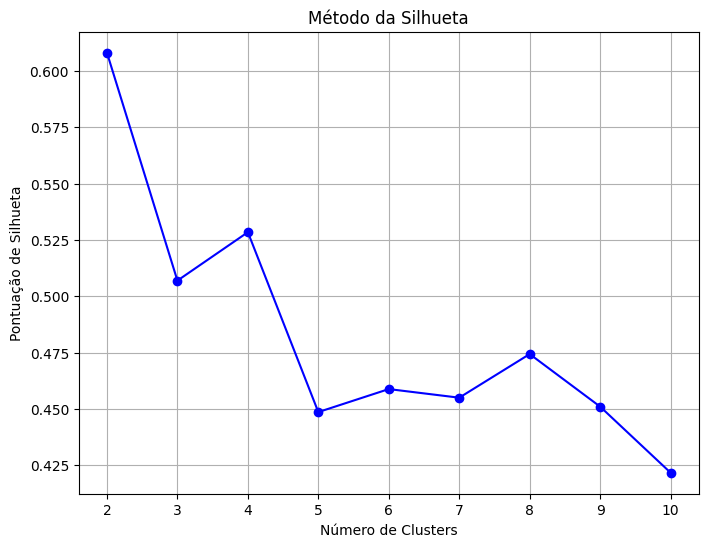

In [97]:
silhouette_scores = []

# Calcular a silhueta para diferentes valores de k
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotar o gráfico do método da silhueta
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Clusters')
plt.ylabel('Pontuação de Silhueta')
plt.title('Método da Silhueta')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


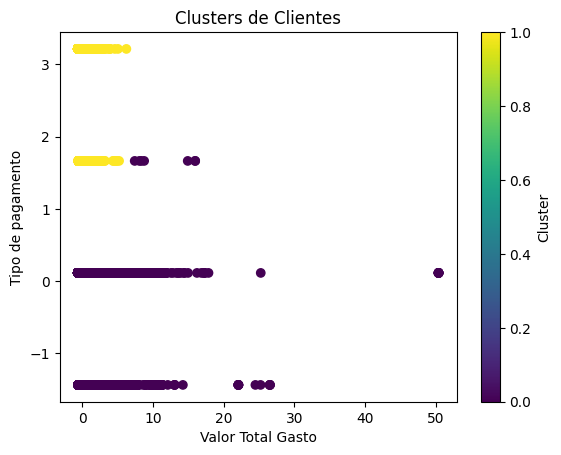

Centroides dos Clusters:
   payment_value  payment_type_encoded  Longitude  payment_type_encoded
0     179.425024              0.791508 -46.428978              0.791508
1      80.041720              2.788435 -46.059989              2.788435


In [99]:
# Escolher o número de clusters (substitua k pelo número de clusters desejado)
k = 2

# Criar o modelo de clusterização com o algoritmo K-means
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

# Adicionar os rótulos dos clusters aos dados
df['Cluster'] = kmeans.labels_

# Visualizar os clusters
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Valor Total Gasto')
plt.ylabel('Tipo de pagamento')
plt.title('Clusters de Clientes')
plt.colorbar(label='Cluster')
plt.show()

# Análise dos centroides (médias das features para cada cluster)
centroides = scaler.inverse_transform(kmeans.cluster_centers_)
centroides_df = pd.DataFrame(centroides, columns=X.columns)
print("Centroides dos Clusters:")
print(centroides_df)